# Analyze Emotion Tweets Dataset

## Importing libraries

In [1]:
from datetime import datetime
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns
sns.set()
import spacy
from spacy import displacy
from py_lex import Liwc, EmoLex
from wordcloud import WordCloud, STOPWORDS
from collections import Counter

## Initial Setup

In [2]:
nlp = spacy.load("pt_core_news_sm")
lexicon = EmoLex('./NRC-Sentiment-Emotion-Lexicons/lexicon_portuguse.txt')

## Main Functions

In [3]:
def get_sentiments(txt):
    doc = nlp(txt)
    tokens = [token for token in doc]
    list_of_strings  = [i.text for i in tokens]
    summary = lexicon.summarize_doc(list_of_strings)
    return summary

def get_list_sentiments(txt):
    doc = nlp(txt)
    tokens = [token for token in doc]
    list_of_strings  = [i.text for i in tokens]
    annotation = lexicon.annotate_doc(list_of_strings)
    return annotation

def show_annotation(txt):
    lst = txt.split()
    sent = get_list_sentiments(txt)
    for i in range (0, len(lst)):
        print (lst[i], end = ' ')
        if sent[i] != set():
            print (" ==> ", sent[i])
        else:
            print (" ")

In [4]:
def plot_emotions(df):
    total_sentiments = pd.DataFrame(df.sum()[['fear', 'sadness', 'surprise', 'trust', 'joy', 'anticipation', 'anger', 'disgust']].sort_values(ascending=False))
    colors = ['grey', 'midnightblue', 'lightskyblue', 'orange', 'yellow', 'pink', 'orangered', 'olive']
    total_sentiments.columns = ['value']

    fig, ax = plt.subplots(figsize=(20,10))
    ax = sns.barplot(x=total_sentiments.index, y='value', data=total_sentiments, palette=sns.color_palette(colors))
    plt.ylabel("")
    plt.xlabel('Emotion', fontsize=20)
    plt.title('Distribution of values from NRC emotions', fontsize=25)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(20) 
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(20)
    sns.despine()
    plt.plot();
    return total_sentiments

In [5]:
def get_words_emotions(df):
    columns = [
        'word', 'fear', 'sadness', 'surprise', 'trust', 'joy', 'anticipation',
        'anger', 'disgust', 'positive', 'negative'
    ]
    word_appearances_by_sentiment = pd.DataFrame(columns=columns)
    for index, _ in df.iterrows():
        txt = df.clean_text[index]
        doc = nlp(txt)
        tokens = [token for token in doc]
        list_of_strings = [i.text for i in tokens]
        annotation = lexicon.annotate_doc(list_of_strings)
        for token, a_set in zip(list_of_strings, annotation):
            row = [token] + [x in a_set for x in columns[1:]]
            appending_df = pd.DataFrame([row], columns=columns)
            word_appearances_by_sentiment = word_appearances_by_sentiment.append(
                appending_df)

    word_appearances_by_sentiment = word_appearances_by_sentiment.groupby(
        "word").agg({
            'fear': np.sum,
            'sadness': np.sum,
            'surprise': np.sum,
            'trust': np.sum,
            'joy': np.sum,
            'anticipation': np.sum,
            'anger': np.sum,
            'disgust': np.sum,
            'positive': np.sum,
            'negative': np.sum
        })
    plot_top_words_by_sentiment(word_appearances_by_sentiment)
    return word_appearances_by_sentiment

In [6]:
def plot_top_words_by_sentiment(df):
    columns = ['word','fear', 'sadness', 'surprise', 'trust', 'joy', 'anticipation', 'anger', 'disgust', 'positive', 'negative']
    ROWS = 3
    COLS = 4
    cols_to_iterate = columns[1:]
    colors = ['grey', 'midnightblue', 'lightskyblue', 'orange', 'yellow', 'pink', 'orangered', 'olive', 'cornflowerblue', 'crimson']
    fig, axes = plt.subplots(nrows=ROWS, ncols=COLS, figsize=(30,20))
    words_which_appear = []
    for row in range(ROWS):
        for col in range(COLS):
            if not cols_to_iterate:
                break
            a_column = cols_to_iterate.pop(0)
            a_color = colors.pop(0)
            a_df = pd.DataFrame(df.sort_values(by=[a_column], ascending=False)[a_column][:10])
            words_which_appear.extend(a_df.index)
            a_df.columns = ['count']
            sns.barplot(a_df['count'], a_df.index,orient='h', color=a_color, ax=axes[row, col])
            axes[row, col].set_title('Top words for %s' % a_column, fontsize=25)
            if max(a_df['count']) > 90:
                axes[row, col].set_xticks(range(0,max(a_df['count']), 15))
            else:
                axes[row, col].set_xticks(range(0,80, 15))
            for tick in axes[row, col].xaxis.get_major_ticks():
                tick.label.set_fontsize(20) 
            for tick in axes[row, col].yaxis.get_major_ticks():
                tick.label.set_fontsize(20)
            axes[row, col].set_ylabel("")
            axes[row, col].set_xlabel("")

    words_which_appear = Counter(words_which_appear)        
    sns.despine()
    plt.tight_layout()
    plt.show();

In [7]:
def plot_feature_timeline(data, feature="favorites", title="user"):
    x = data.created_at
    fea = np.array(data[feature])
    fea_max = max(fea)
    fea_min = min(fea)
    fig, ax = plt.subplots(figsize=(20,10))
    plt.title(title+" - "+feature+" tweets in time", fontsize=20);
    plt.ylabel("Quantity", fontsize=20)
    plt.xlabel('Date', fontsize=20)
    plt.plot(x, fea);
    style = dict(size=15, color='red')
    if min(x) < datetime(2018, 4, 7):
        ax.text('2018-4-7', fea_min - fea_max/30, "| Lula's prison", **style)
    ax.text('2018-9-6', fea_min - fea_max/30, "| Outrage", **style)
    ax.text('2018-10-7', fea_min - fea_max/30, "| 1st ", **style)
    ax.text('2018-10-28', fea_min - fea_max/30, "| 2nd round", **style)

In [8]:
def show_tweet_annotation_by_index (tweet_index):
    print(data.text[tweet_index])
    print("\n [TEXT ANNOTATION]\n")
    show_annotation(data.clean_text[tweet_index])

## Load Dataset

In [9]:
!ls ./tweets_dataset

BlogDoPim_emot_tweets.csv       LulaOficial_emot_tweets.csv
BolsonaroSP_emot_tweets.csv     df_emot_tweets.csv
CarlosBolsonaro_emot_tweets.csv gleisi_emot_tweets.csv
FlavioBolsonaro_emot_tweets.csv jairbolsonaro_emot_tweets.csv
Haddad_Fernando_emot_tweets.csv


In [10]:
df = pd.read_csv('./tweets_dataset/df_emot_tweets.csv')
df.shape

(25651, 17)

In [11]:
df.sample(5)

,Unnamed: 0,created_at,retweets,favorites,text,clean_text,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,screen_name
14688,1949,2018-09-21 01:35:55,453.0,0.0,RT @Haddad_Fernando: O senhor @meirelles pode ...,senhor recuperar confiança banqueiro recuperar...,0.0000,0.000000,0.166667,0.333333,0.333333,0.166667,0.5,0.0000,0.000000,0.666667,LulaOficial
7947,1612,2018-12-25 11:21:08,1282.0,6682.0,Justiça ordena que facebook bote no ar página ...,justiça ordenar facebook botar ar página direi...,0.0000,0.000000,0.000000,0.062500,0.000000,0.125000,0.0625,0.0625,0.000000,0.062500,BolsonaroSP
25024,2588,2016-09-27 19:10:17,78.0,0.0,RT @esuplicy: Estarei com o prefeito @Haddad_F...,estarei prefeito 18h30 casa portugal atar dire...,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.25,0.0000,0.000000,0.000000,Haddad_Fernando
17400,1424,2018-04-14 20:14:54,515.0,1119.0,"Incomodados com o apoio ao ex-presidente Lula,...",incomodados apoiar ex-presidente lula decisão ...,0.0625,0.062500,0.000000,0.062500,0.000000,0.062500,0.1875,0.0625,0.000000,0.125000,gleisi
20713,1496,2018-10-26 21:27:28,138.0,943.0,"Assista AO VIVO a #OsPingosNosIs, das 18h30 às...",assista vivo 18h30 s 20h informação análise di...,0.0000,0.153846,0.000000,0.000000,0.153846,0.000000,0.23076923076923078,0.0000,0.076923,0.153846,BlogDoPim


In [12]:
df.isnull().values.any()

True

In [13]:
nan_rows = df[df.isnull().T.any().T]

In [14]:
nan_rows.head()

,Unnamed: 0,created_at,retweets,favorites,text,clean_text,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,screen_name
53,53,2019-03-25 14:01:20,4030.0,25812.0,https://t.co/0hI00peP16,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,jairbolsonaro
117,117,2019-03-18 09:08:45,18.0,599.0,@Moninha86732005 @Astro_Pontes Bom Dia!,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,jairbolsonaro
151,151,2019-03-12 21:32:41,4259.0,29147.0,https://t.co/kENIbxh0jU,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,jairbolsonaro
182,182,2019-03-08 16:08:26,3216.0,21736.0,https://t.co/PxuX2Xp0Ma,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,jairbolsonaro
257,257,2019-02-24 15:48:06,1796.0,14603.0,"Um bom trabalho, @BolsonaroSP ! https://t.co/U...",NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,jairbolsonaro


In [15]:
df = df.dropna()

In [16]:
df.shape

(24969, 17)

In [17]:
df.isnull().values.any()

False

## Temporal Analysis

In [18]:
df.dtypes

Unnamed: 0       object
created_at       object
retweets        float64
favorites       float64
text             object
clean_text       object
anger           float64
anticipation    float64
disgust         float64
fear            float64
joy             float64
negative        float64
positive         object
sadness         float64
surprise        float64
trust           float64
screen_name      object
dtype: object

In [19]:
df['created_at'] = pd.to_datetime(df['created_at'])

In [20]:
df['positive'] = df['positive'].astype('float64')

In [21]:
df.dtypes

Unnamed: 0              object
created_at      datetime64[ns]
retweets               float64
favorites              float64
text                    object
clean_text              object
anger                  float64
anticipation           float64
disgust                float64
fear                   float64
joy                    float64
negative               float64
positive               float64
sadness                float64
surprise               float64
trust                  float64
screen_name             object
dtype: object

In [22]:
# Filter tweets older than 2018
data = df[df.created_at >= '2018-1-1 0:0:0']

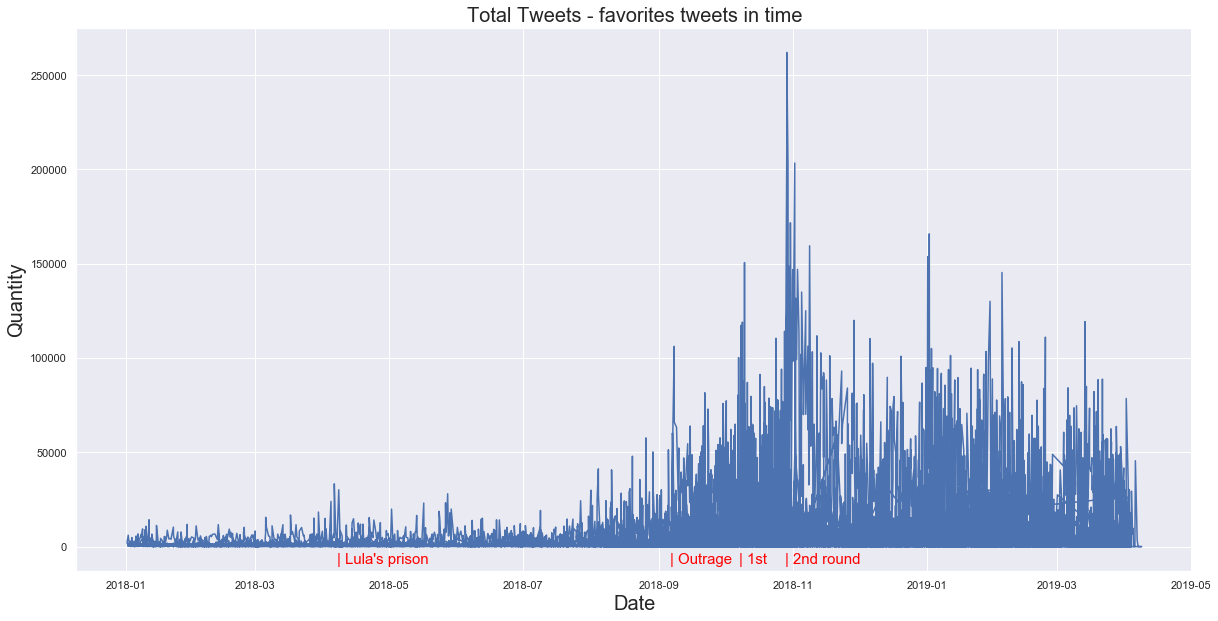

In [23]:
plot_feature_timeline(data, title="Total Tweets")

### View Favorites trend by screen_name

In [24]:
data.screen_name.value_counts()

BlogDoPim          3206
BolsonaroSP        3181
LulaOficial        3086
CarlosBolsonaro    3034
jairbolsonaro      2665
Haddad_Fernando    2211
gleisi             2058
FlavioBolsonaro    1069
Name: screen_name, dtype: int64

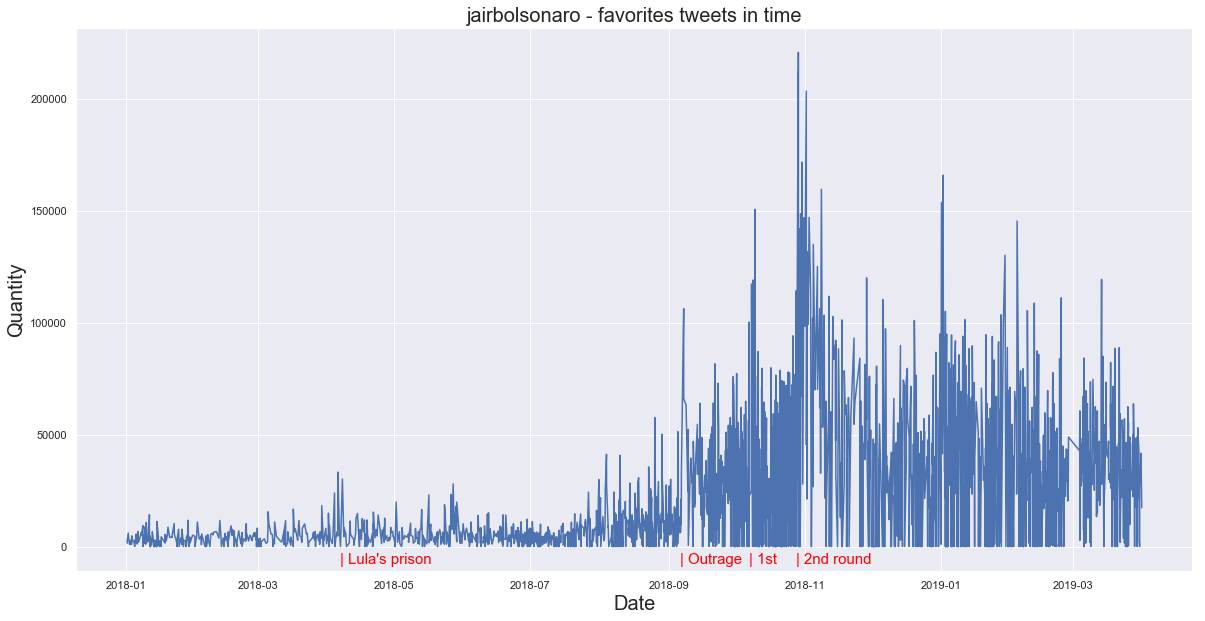

In [25]:
screen_name = 'jairbolsonaro'
jb = data[data.screen_name == screen_name] 
plot_feature_timeline(jb, title=screen_name)

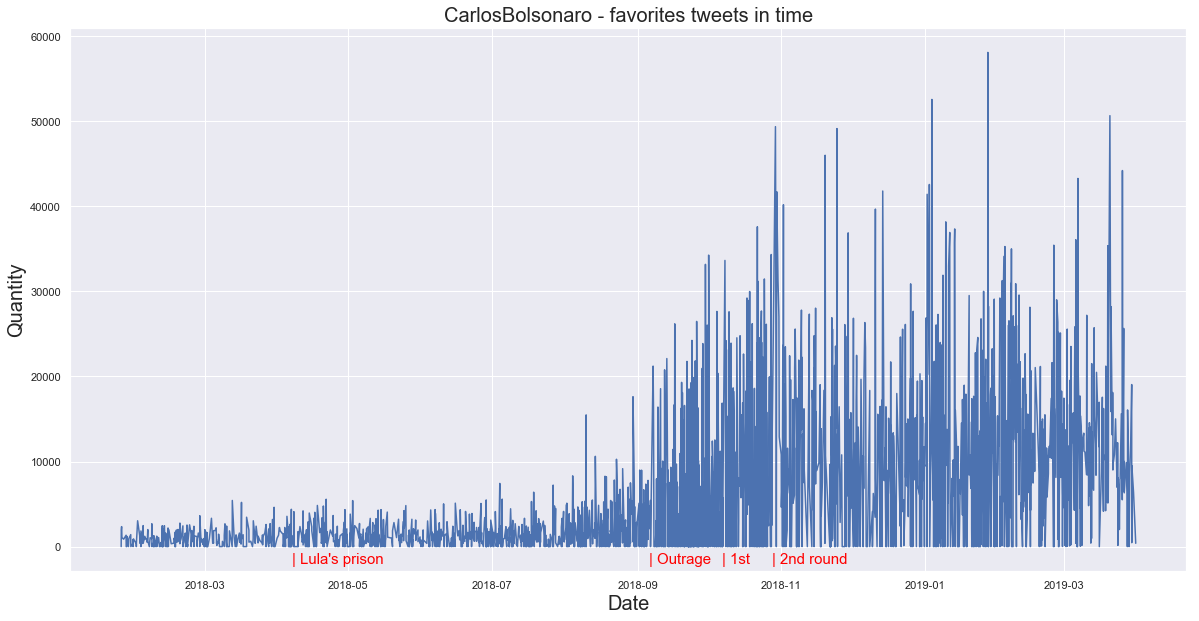

In [26]:
screen_name = 'CarlosBolsonaro'
dt = data[data.screen_name == screen_name] 
plot_feature_timeline(dt, title=screen_name)

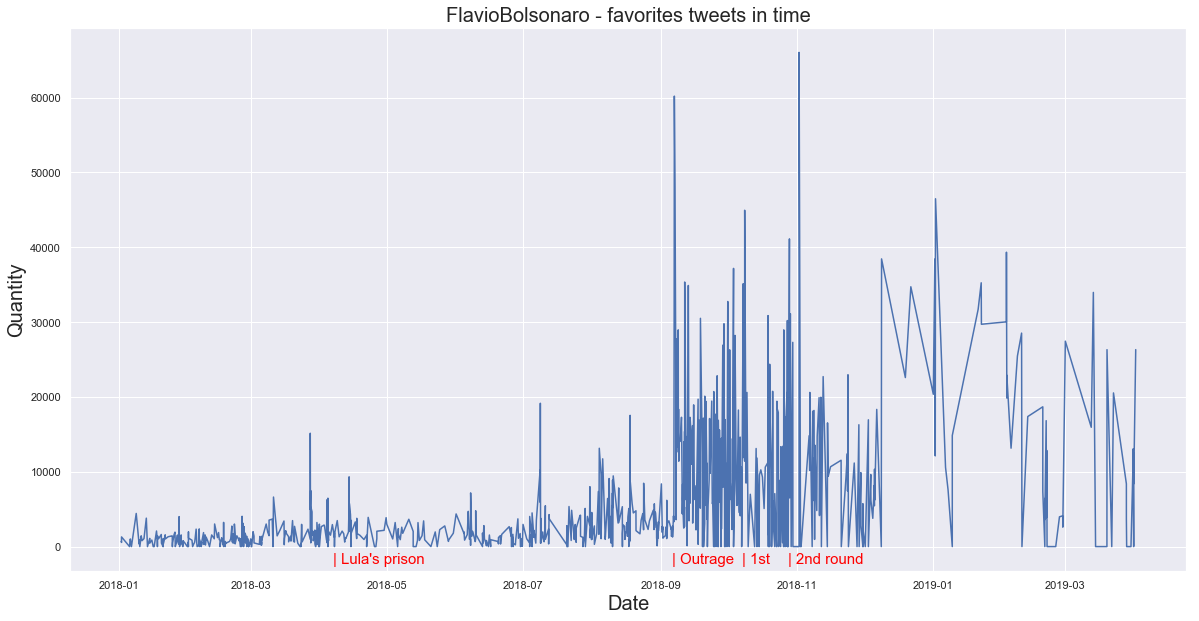

In [27]:
screen_name = 'FlavioBolsonaro'
dt = data[data.screen_name == screen_name] 
plot_feature_timeline(dt, title=screen_name)

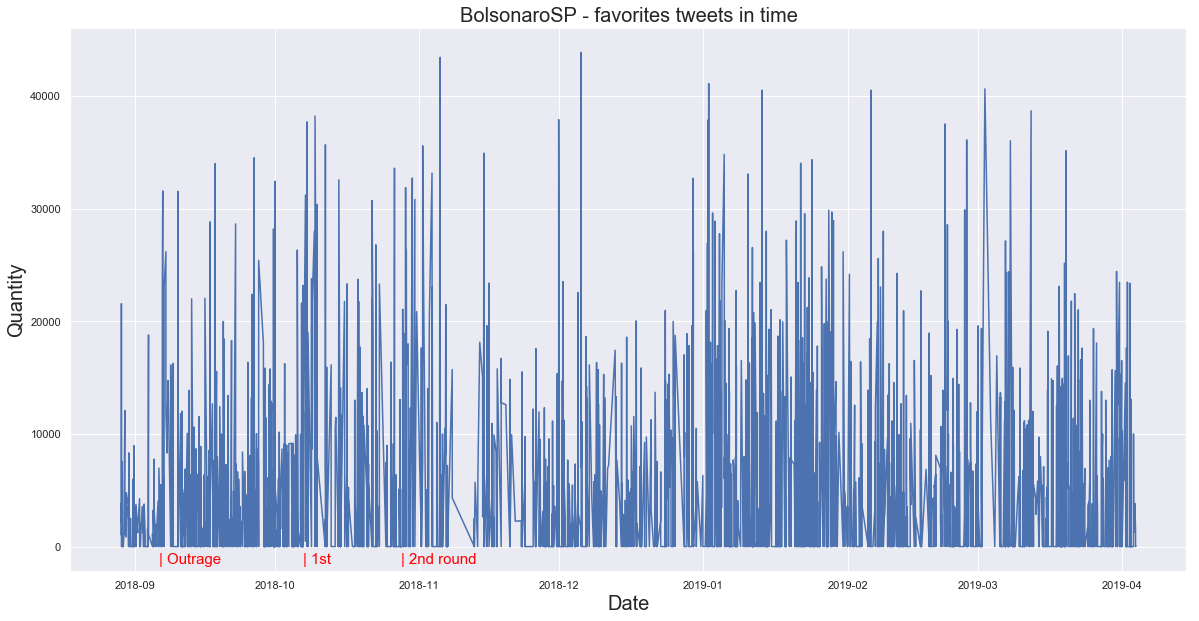

In [28]:
screen_name = 'BolsonaroSP'
dt = data[data.screen_name == screen_name] 
plot_feature_timeline(dt, title=screen_name)

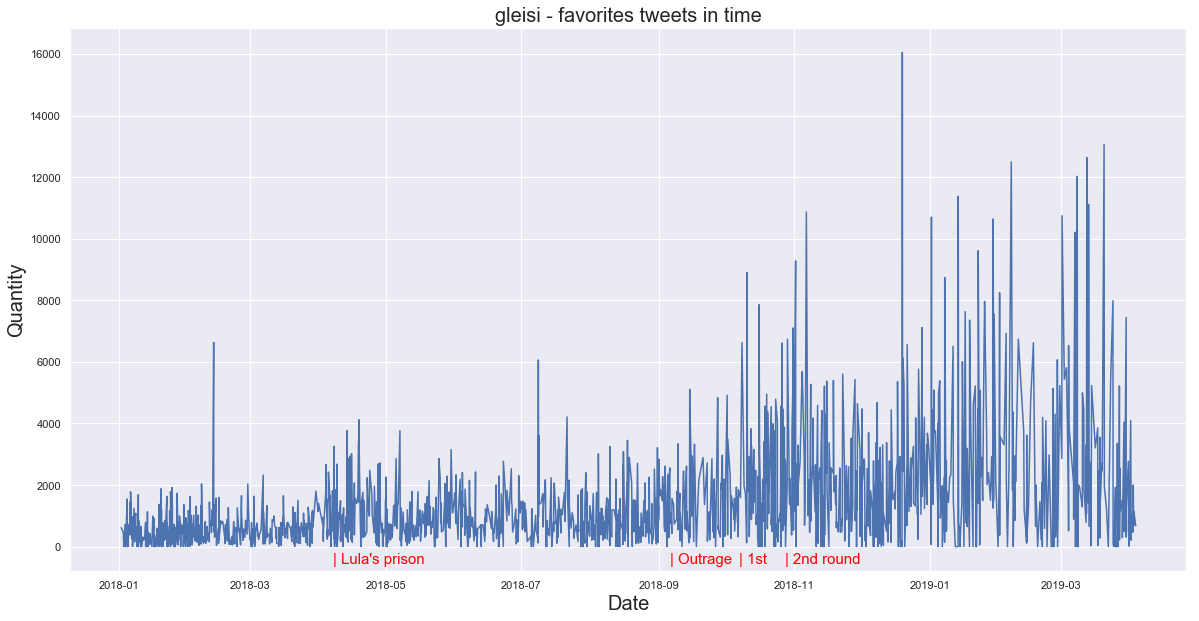

In [29]:
screen_name = 'gleisi'
dt = data[data.screen_name == screen_name] 
plot_feature_timeline(dt, title=screen_name)

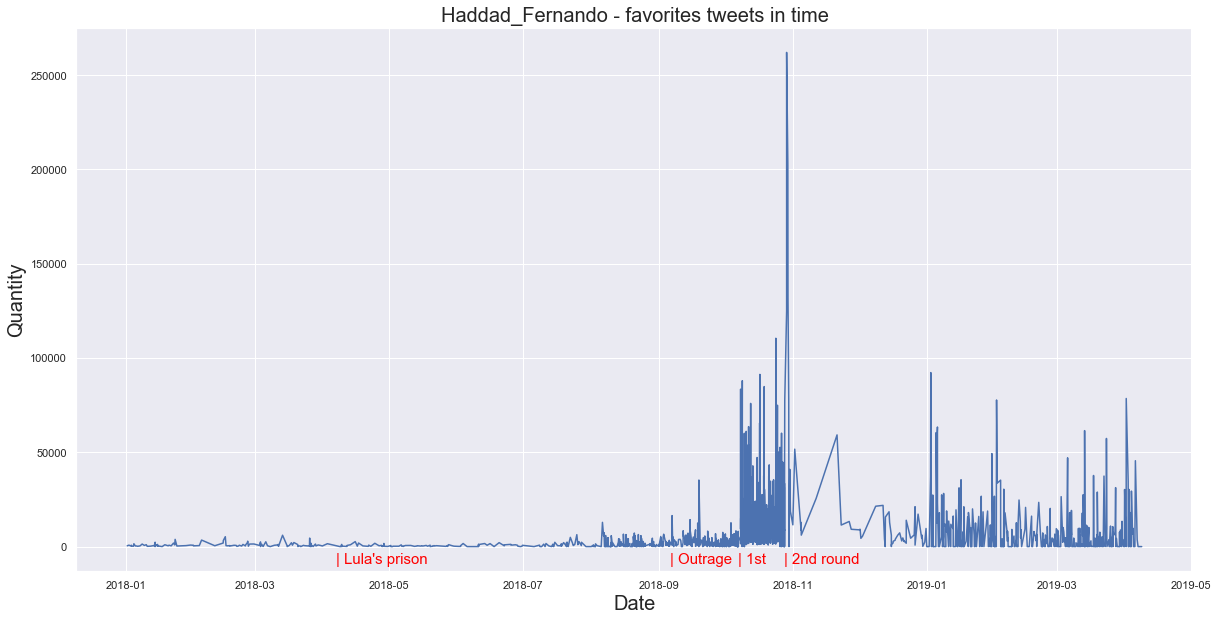

In [30]:
screen_name = 'Haddad_Fernando'
dt = data[data.screen_name == screen_name] 
plot_feature_timeline(dt, title=screen_name)

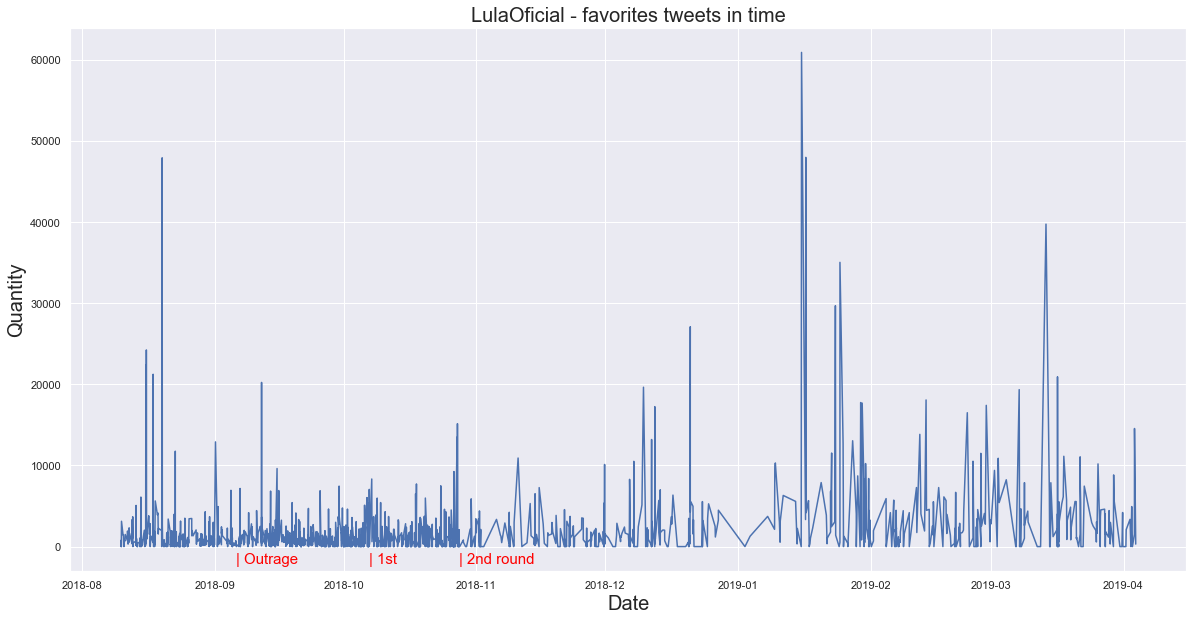

In [31]:
screen_name = 'LulaOficial'
dt = data[data.screen_name == screen_name] 
plot_feature_timeline(dt, title=screen_name)

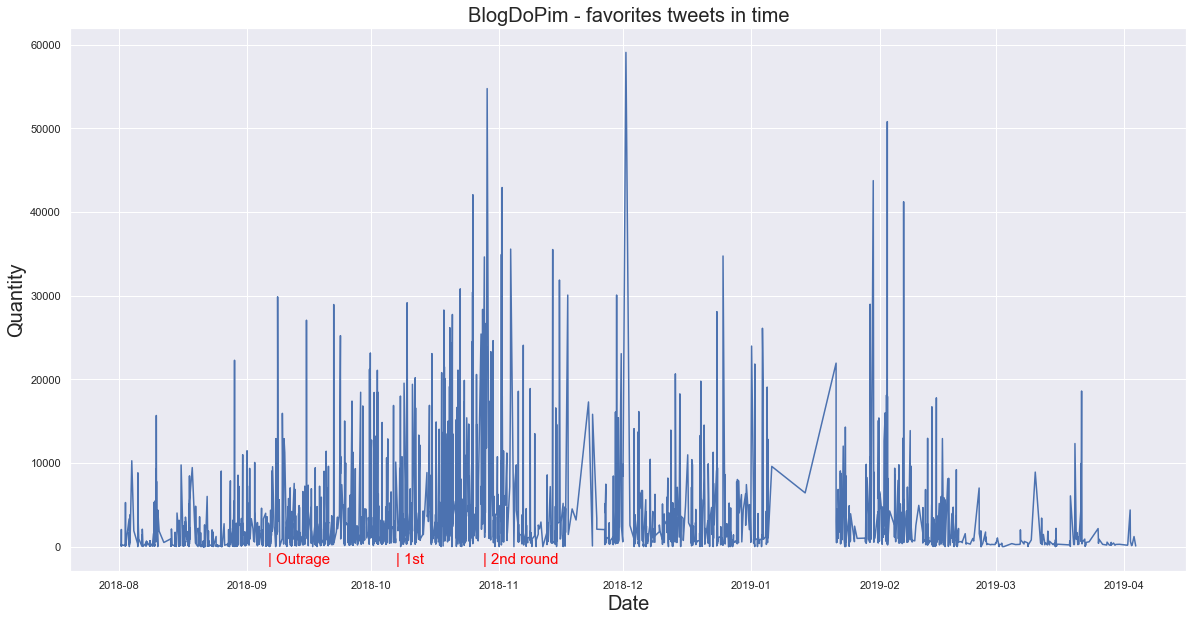

In [32]:
screen_name = 'BlogDoPim'
dt = data[data.screen_name == screen_name] 
plot_feature_timeline(dt, title=screen_name)

### Looking on top favorites on tweets

In [33]:
# Top Tweets
data[data.favorites > 150_000].sort_values("favorites", ascending=False)

,Unnamed: 0,created_at,retweets,favorites,text,clean_text,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,screen_name
22927,491,2018-10-28 23:12:42,42286.0,261988.0,Gostaria de agradecer os 45 milhões de eleitor...,gostaria agradecer 45 milhão eleitor acompanha...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.200000,0.000000,0.000000,0.000000,Haddad_Fernando
1036,1036,2018-10-29 01:06:50,43820.0,220590.0,Recebemos há pouco ligação do Presidente dos E...,recebemos haver ligação presidente eua paraben...,0.000000,0.125000,0.000000,0.062500,0.187500,0.062500,0.250000,0.000000,0.125000,0.187500,jairbolsonaro
1039,1039,2018-10-28 23:13:01,52111.0,211913.0,BRASIL! 🇧🇷👍🏻,brasil 🇧 🇷 👍 🏻,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,jairbolsonaro
1005,1005,2018-11-01 14:25:24,42808.0,203340.0,O juiz federal Sérgio Moro aceitou nosso convi...,juiz federal sérgio moro aceitar convite parir...,0.000000,0.047619,0.000000,0.000000,0.047619,0.000000,0.285714,0.000000,0.000000,0.142857,jairbolsonaro
22926,490,2018-10-29 12:36:16,26645.0,202290.0,Presidente Jair Bolsonaro. Desejo-lhe sucesso....,presidente jair bolsonaro desejo-lhe sucesso p...,0.055556,0.111111,0.000000,0.000000,0.055556,0.000000,0.222222,0.000000,0.000000,0.111111,Haddad_Fernando
1011,1011,2018-10-30 14:54:22,29633.0,171646.0,"Nossa campanha custou cerca de R$ 1,5 milhão, ...","campanha custar cercar r$ 1,5 milhão arrecadar...",0.043478,0.043478,0.000000,0.043478,0.000000,0.173913,0.130435,0.043478,0.000000,0.130435,jairbolsonaro
726,726,2019-01-01 20:50:14,22736.0,165790.0,🇧🇷🇧🇷🇧🇷 https://t.co/8CJw5quv2z,🇧 🇷 🇧 🇷 🇧 🇷,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,jairbolsonaro
981,981,2018-11-08 08:41:38,27448.0,159465.0,Firmo o compromisso de iniciar o meu mandato d...,firmo compromisso mandatar determinar abrir ca...,0.066667,0.133333,0.000000,0.066667,0.133333,0.200000,0.200000,0.133333,0.133333,0.266667,jairbolsonaro
732,732,2019-01-01 04:21:31,21366.0,153683.0,FELIZ 2019 🇧🇷🇧🇷🇧🇷,feliz 2019 🇧 🇷 🇧 🇷 🇧 🇷,0.000000,0.500000,0.000000,0.000000,0.500000,0.000000,0.500000,0.000000,0.000000,0.500000,jairbolsonaro
1383,1383,2018-10-09 17:13:15,42787.0,150577.0,Meu adversário falou que vai combater o encarc...,adversário falar combater encarceramento solta...,0.086957,0.043478,0.086957,0.304348,0.000000,0.304348,0.130435,0.173913,0.000000,0.086957,jairbolsonaro


In [34]:
show_tweet_annotation_by_index (22927) # Haddad

Gostaria de agradecer os 45 milhões de eleitores que nos acompanharam. Uma parte expressiva da população que precisa ser respeitada.

 [TEXT ANNOTATION]

gostaria  
agradecer  
45  
milhão  
eleitor  
acompanhar  
expressivo  
população  ==>  {'positive'}
preciso  ==>  {'positive'}
respeitar  


In [35]:
show_tweet_annotation_by_index (1036) # Bolsonaro

Recebemos há pouco ligação do Presidente dos EUA, @realDonaldTrump nos parabenizando por esta eleição histórica! Manifestamos o desejo de aproximar ainda mais estas duas grande nações e avançarmos no caminho da liberdade e da prosperidade!

 [TEXT ANNOTATION]

recebemos  
haver  
ligação  ==>  {'negative'}
presidente  ==>  {'positive', 'trust'}
eua  
parabenizar  
eleição  
histórico  
manifestamos  
desejar  
aproximar  
nação  ==>  {'trust'}
avançar  ==>  {'surprise', 'joy', 'anticipation', 'positive', 'fear'}
caminhar  
liberdade  ==>  {'surprise', 'joy', 'anticipation', 'positive', 'trust'}
prosperidade  ==>  {'joy', 'positive'}


In [36]:
show_tweet_annotation_by_index (1039) # Bolsonaro

BRASIL! 🇧🇷👍🏻

 [TEXT ANNOTATION]

brasil  
🇧  
🇷  
👍  
🏻  


In [37]:
show_tweet_annotation_by_index (1005) # Bolsonaro

O juiz federal Sérgio Moro aceitou nosso convite para o Ministério da Justiça e Segurança Pública. Sua agenda anti-corrupção, anti-crime organizado, bem como respeito à Constituição e às leis será o nosso norte!

 [TEXT ANNOTATION]

juiz  
federal  
sérgio  
moro  
aceitar  
convite  ==>  {'anticipation', 'positive'}
parir  
ministério  ==>  {'joy', 'positive', 'trust'}
justiça  ==>  {'positive', 'trust'}
segurança  ==>  {'positive'}
pública  
agendar  
anti-corrupção  
anti-crime  
organizar  ==>  {'positive'}
comer  ==>  {'positive'}
respeitar  
constituição  
s  
lei  ==>  {'trust'}
norte  


In [38]:
show_tweet_annotation_by_index (22926) # Haddad

Presidente Jair Bolsonaro. Desejo-lhe sucesso. Nosso país merece o melhor. Escrevo essa mensagem, hoje, de coração leve,  com sinceridade, para que ela estimule o melhor de todos nós. Boa sorte!

 [TEXT ANNOTATION]

presidente  ==>  {'positive', 'trust'}
jair  
bolsonaro  
desejo-lhe  
sucesso  ==>  {'anticipation', 'joy', 'positive'}
país  
merecer  ==>  {'anticipation', 'anger', 'positive', 'trust'}
melhor  
escrevo  
mensagem  
coração  
levar  
sinceridade  ==>  {'positive'}
parir  
estimular  
melhor  
nó  
sortir  


In [39]:
show_tweet_annotation_by_index (1011) # Bolsonaro

Nossa campanha custou cerca de R$ 1,5 milhão, menos que a metade do que foi arrecadado com doações individuais. Pretendo doar o restante para a Santa Casa de Juiz de Fora, onde nasci novamente. Acredito que aqueles que em mim confiaram estarão de acordo. Muito obrigado a todos!

 [TEXT ANNOTATION]

campanha  ==>  {'negative', 'anger', 'fear'}
custar  
cercar  ==>  {'anticipation', 'positive', 'negative'}
r$  
1,5  
milhão  
arrecadar  
doação  ==>  {'sadness', 'negative', 'positive', 'trust'}
individuar  
pretendo  
doar  
restante  
parir  
santa  
casa  ==>  {'positive'}
juiz  
nascer  
novamente  
acredito  
mim  
confiar  ==>  {'trust'}
acordar  
obrigar  ==>  {'negative', 'trust'}


In [40]:
show_tweet_annotation_by_index (726) # Bolsonaro ==> Inauguration photo

🇧🇷🇧🇷🇧🇷 https://t.co/8CJw5quv2z

 [TEXT ANNOTATION]

🇧  
🇷  
🇧  
🇷  
🇧  
🇷  


In [41]:
show_tweet_annotation_by_index (981) # Bolsonaro

Firmo o compromisso de iniciar o meu mandato determinado a abrir a caixa preta do BNDES e revelar ao povo brasileiro o que feito com seu dinheiro nos últimos anos. Acredito que este é um anseio de todos. Um forte abraço!

 [TEXT ANNOTATION]

firmo  
compromisso  ==>  {'negative', 'sadness'}
mandatar  
determinar  
abrir  
caixa  ==>  {'trust'}
preto  ==>  {'negative', 'sadness'}
bndes  
revelar  
brasileiro  
dinheiro  ==>  {'surprise', 'joy', 'anticipation', 'anger', 'positive', 'fear', 'trust'}
acredito  
ansiar  
forte  ==>  {'negative', 'positive', 'trust'}
abraçar  ==>  {'surprise', 'joy', 'anticipation', 'positive', 'trust'}


In [42]:
show_tweet_annotation_by_index (732) # Bolsonaro

FELIZ 2019 🇧🇷🇧🇷🇧🇷

 [TEXT ANNOTATION]

feliz  ==>  {'joy', 'anticipation', 'positive', 'trust'}
2019  
🇧  
🇷  
🇧  
🇷  
🇧  
🇷  


In [43]:
show_tweet_annotation_by_index (1383) # Bolsonaro

Meu adversário falou que vai combater o encarceramento e soltar criminosos da cadeia. Nossa preocupação e prioridade são as pessoas de bem. Falo desde sempre, prefiro uma cadeia lotada de criminosos do que um cemitério lotado de inocentes. Se faltar espaço, a gente constrói mais!

 [TEXT ANNOTATION]

adversário  ==>  {'negative', 'anticipation', 'anger', 'fear', 'disgust'}
falar  
combater  
encarceramento  ==>  {'sadness', 'negative', 'anger', 'fear', 'disgust'}
soltar  
criminoso  ==>  {'negative', 'fear'}
cadeia  ==>  {'negative', 'fear', 'sadness'}
preocupação  
prioridade  
pessoa  
falo  
preferir  ==>  {'positive', 'trust'}
umar  
cadeia  ==>  {'negative', 'fear', 'sadness'}
lotar  
criminoso  ==>  {'negative', 'fear'}
cemitério  ==>  {'negative', 'fear', 'sadness'}
lotar  
inocente  ==>  {'positive', 'trust'}
faltar  
espaçar  
gente  
construir  ==>  {'positive'}


### Creating Polarity feature

In [44]:
data['polarity'] = data.apply(lambda row: (row.positive*100) - (row.negative*100), axis=1)

/Users/mjrovai/anaconda3/envs/python_3_6/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [45]:
screen_name = 'jairbolsonaro'
dt = data[data.screen_name == screen_name] 

In [46]:
dt.tail()

,Unnamed: 0,created_at,retweets,favorites,text,clean_text,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,screen_name,polarity
2705,2705,2018-01-02 23:04:29,172.0,939.0,TRANSFORMANDO OS MÉTODOS DE CULTURA E A EDUCAÇ...,transformando métodos cultura educação aplicad...,0.055556,0.000000,0.111111,0.055556,0.000000,0.055556,0.111111,0.00,0.000000,0.055556,jairbolsonaro,5.555556e+00
2706,2706,2018-01-02 12:29:15,209.0,1252.0,O BRASIL POSSUI INTELIGÊNCIA ESTRATÉGICA? Créd...,brasil possui inteligência estratégica crédito...,0.000000,0.000000,0.000000,0.285714,0.142857,0.000000,0.285714,0.00,0.000000,0.285714,jairbolsonaro,2.857143e+01
2707,2707,2018-01-02 00:51:41,458.0,6036.0,Remexendo numas fotos e relembrando bons tempo...,remexendo foto relembrar semana,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,0.000000,jairbolsonaro,0.000000e+00
2708,2708,2018-01-01 13:32:17,578.0,2657.0,Sites de esquerda e/ou oportunistas ironizaram...,sites esquerdo oportunista ironizar pré-natal ...,0.000000,0.058824,0.000000,0.000000,0.000000,0.058824,0.058824,0.00,0.058824,0.000000,jairbolsonaro,-8.881784e-16
2709,2709,2018-01-01 13:30:38,244.0,1536.0,O ano mal começou e a fakenews acordou voraz! ...,começar fakenews acordar voraz,0.250000,0.000000,0.000000,0.250000,0.000000,0.250000,0.000000,0.25,0.000000,0.000000,jairbolsonaro,-2.500000e+01


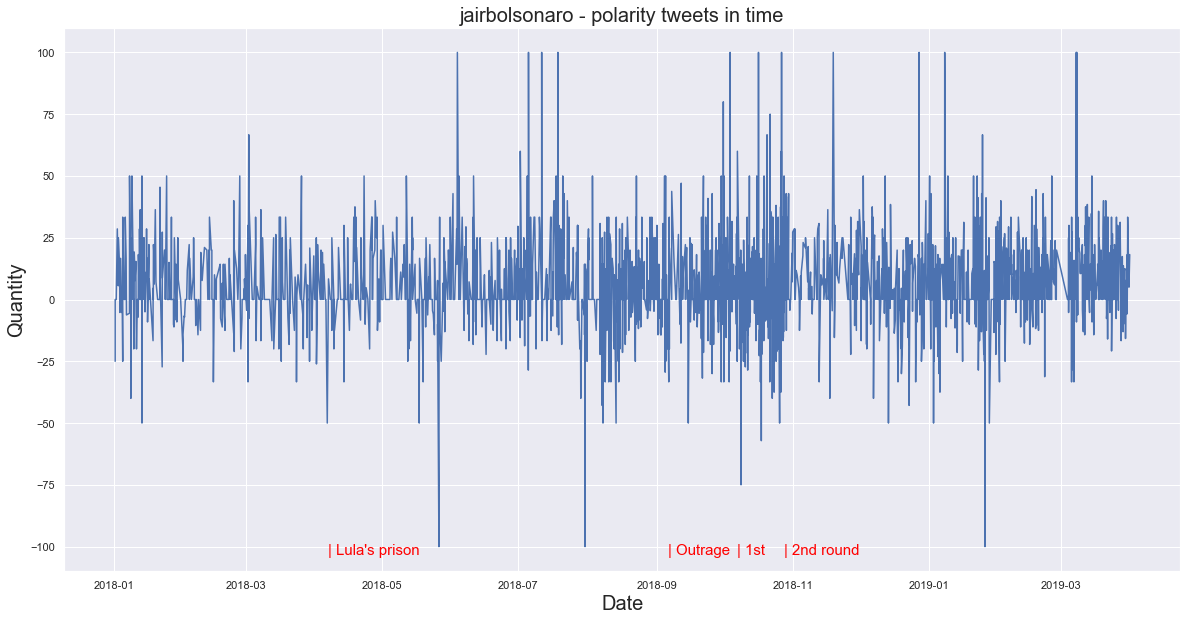

In [47]:
screen_name = 'jairbolsonaro'
dt = data[data.screen_name == screen_name]
plot_feature_timeline(dt, feature='polarity', title=screen_name)

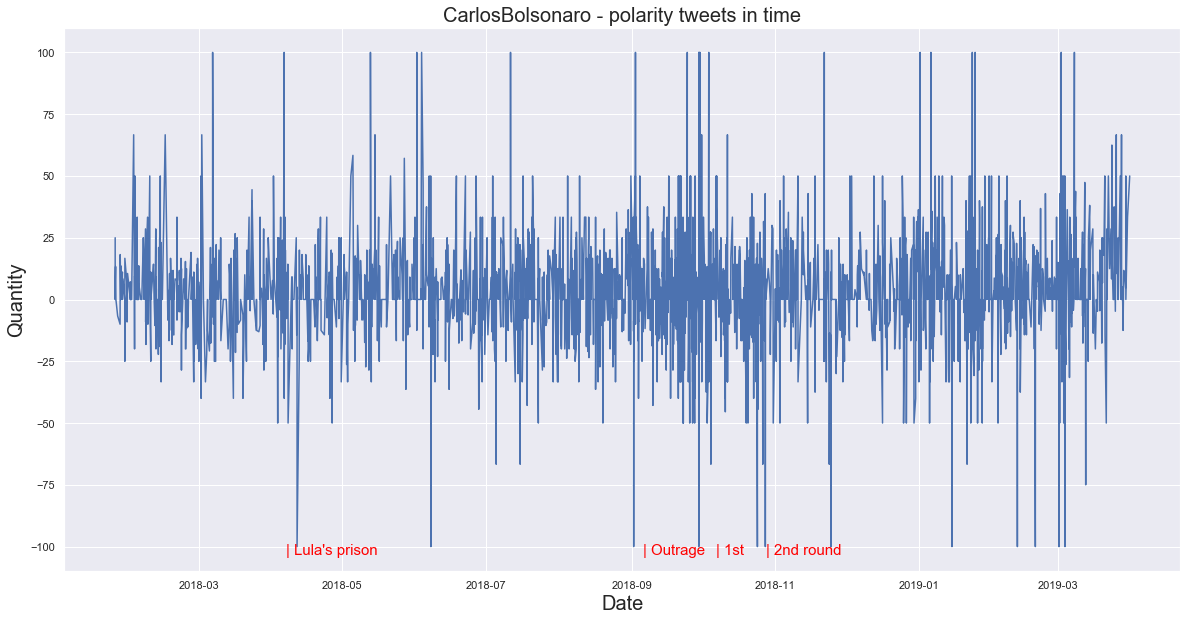

In [48]:
screen_name = 'CarlosBolsonaro'
dt = data[data.screen_name == screen_name]
plot_feature_timeline(dt, feature='polarity', title=screen_name)

In [49]:
screen_name = 'jairbolsonaro'
dt_pos = data[(data.screen_name == screen_name) & (data.polarity >0)]
dt_neg = data[(data.screen_name == screen_name) & (data.polarity <0)]

In [50]:
print ("Number of Positive tweets: ", len(dt_pos))
print ("Number of Negative tweets: ", len(dt_neg))

Number of Positive tweets:  1188
Number of Negative tweets:  492


**Exploring the 5 most negative tweets**

In [51]:
dt_neg.sort_values("polarity", ascending=True).head()

,Unnamed: 0,created_at,retweets,favorites,text,clean_text,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,screen_name,polarity
1940,1940,2018-07-30 21:46:50,89.0,1510.0,o que acontece* 👍🏽,acontecer 👍 🏽,0.000000,1.0,0.000000,0.000000,0.0,1.000000,0.0,0.000000,0.0,0.0,jairbolsonaro,-100.000000
2248,2248,2018-05-26 12:01:59,3249.0,11148.0,"- ""Entre um Governo corrupto e o povo, estamos...",governo corrupto,0.000000,0.0,0.000000,0.500000,0.0,1.000000,0.0,0.000000,0.0,0.0,jairbolsonaro,-100.000000
504,504,2019-01-25 23:17:16,4389.0,33097.0,LAMENTÁVEL! https://t.co/dSjEKnN8fY,lamentável,0.000000,0.0,0.000000,0.000000,0.0,1.000000,0.0,1.000000,0.0,0.0,jairbolsonaro,-100.000000
1391,1391,2018-10-08 18:03:11,29306.0,118994.0,"Meu compromisso é com a minha pátria, não com ...",compromisso pátrio corrupto cadeia,0.000000,0.0,0.000000,0.250000,0.0,0.750000,0.0,0.500000,0.0,0.0,jairbolsonaro,-75.000000
1260,1260,2018-10-17 20:02:37,4112.0,15126.0,A perseguição aos apoiadores de Bolsonaro é al...,perseguição apoiadores bolsonaro escalar absur...,0.285714,0.0,0.142857,0.142857,0.0,0.571429,0.0,0.142857,0.0,0.0,jairbolsonaro,-57.142857


In [52]:
show_tweet_annotation_by_index (1940)

o que acontece* 👍🏽

 [TEXT ANNOTATION]

acontecer  ==>  {'anticipation', 'negative'}
👍  
🏽  


In [53]:
show_tweet_annotation_by_index (1391)

Meu compromisso é com a minha pátria, não com corruptos na cadeia.

 [TEXT ANNOTATION]

compromisso  ==>  {'negative', 'sadness'}
pátrio  
corrupto  ==>  {'negative'}
cadeia  ==>  {'negative', 'fear', 'sadness'}


In [54]:
show_tweet_annotation_by_index (1260)

A perseguição aos apoiadores de Bolsonaro é algo em escala absurda e ignorada propositalmente! https://t.co/fM5Ubv2Cwg

 [TEXT ANNOTATION]

perseguição  ==>  {'sadness', 'negative', 'anger', 'fear', 'disgust'}
apoiadores  
bolsonaro  
escalar  ==>  {'anger', 'negative'}
absurdo  ==>  {'negative'}
ignorar  ==>  {'negative'}
propositalmente  


**Getting relations between positive/negative tweets from all screen_names**

In [55]:
screen_name = 'CarlosBolsonaro'
dt_pos = data[(data.screen_name == screen_name) & (data.polarity >0)]
dt_neg = data[(data.screen_name == screen_name) & (data.polarity <0)]
print ("Number of Positive tweets: ", len(dt_pos))
print ("Number of Negative tweets: ", len(dt_neg))

Number of Positive tweets:  1165
Number of Negative tweets:  766


In [56]:
screen_name = 'FlavioBolsonaro'
dt_pos = data[(data.screen_name == screen_name) & (data.polarity >0)]
dt_neg = data[(data.screen_name == screen_name) & (data.polarity <0)]
print ("Number of Positive tweets: ", len(dt_pos))
print ("Number of Negative tweets: ", len(dt_neg))

Number of Positive tweets:  441
Number of Negative tweets:  259


In [57]:
screen_name = 'BolsonaroSP'
dt_pos = data[(data.screen_name == screen_name) & (data.polarity >0)]
dt_neg = data[(data.screen_name == screen_name) & (data.polarity <0)]
print ("Number of Positive tweets: ", len(dt_pos))
print ("Number of Negative tweets: ", len(dt_neg))

Number of Positive tweets:  1446
Number of Negative tweets:  680


In [58]:
screen_name = 'LulaOficial'
dt_pos = data[(data.screen_name == screen_name) & (data.polarity >0)]
dt_neg = data[(data.screen_name == screen_name) & (data.polarity <0)]
print ("Number of Positive tweets: ", len(dt_pos))
print ("Number of Negative tweets: ", len(dt_neg))

Number of Positive tweets:  1548
Number of Negative tweets:  637


In [59]:
screen_name = 'gleisi'
dt_pos = data[(data.screen_name == screen_name) & (data.polarity >0)]
dt_neg = data[(data.screen_name == screen_name) & (data.polarity <0)]
print ("Number of Positive tweets: ", len(dt_pos))
print ("Number of Negative tweets: ", len(dt_neg))

Number of Positive tweets:  1048
Number of Negative tweets:  487


In [60]:
screen_name = 'Haddad_Fernando'
dt_pos = data[(data.screen_name == screen_name) & (data.polarity >0)]
dt_neg = data[(data.screen_name == screen_name) & (data.polarity <0)]
print ("Number of Positive tweets: ", len(dt_pos))
print ("Number of Negative tweets: ", len(dt_neg))

Number of Positive tweets:  1060
Number of Negative tweets:  463


In [61]:
screen_name = 'BlogDoPim'
dt_pos = data[(data.screen_name == screen_name) & (data.polarity >0)]
dt_neg = data[(data.screen_name == screen_name) & (data.polarity <0)]
print ("Number of Positive tweets: ", len(dt_pos))
print ("Number of Negative tweets: ", len(dt_neg))

Number of Positive tweets:  1136
Number of Negative tweets:  852


### Creating a weighted polarity feature

`Multiply polarity by number of favorites`

In [62]:
data['polarity_pond'] = data.apply(lambda row: (row.polarity) * (row.favorites), axis=1)

/Users/mjrovai/anaconda3/envs/python_3_6/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


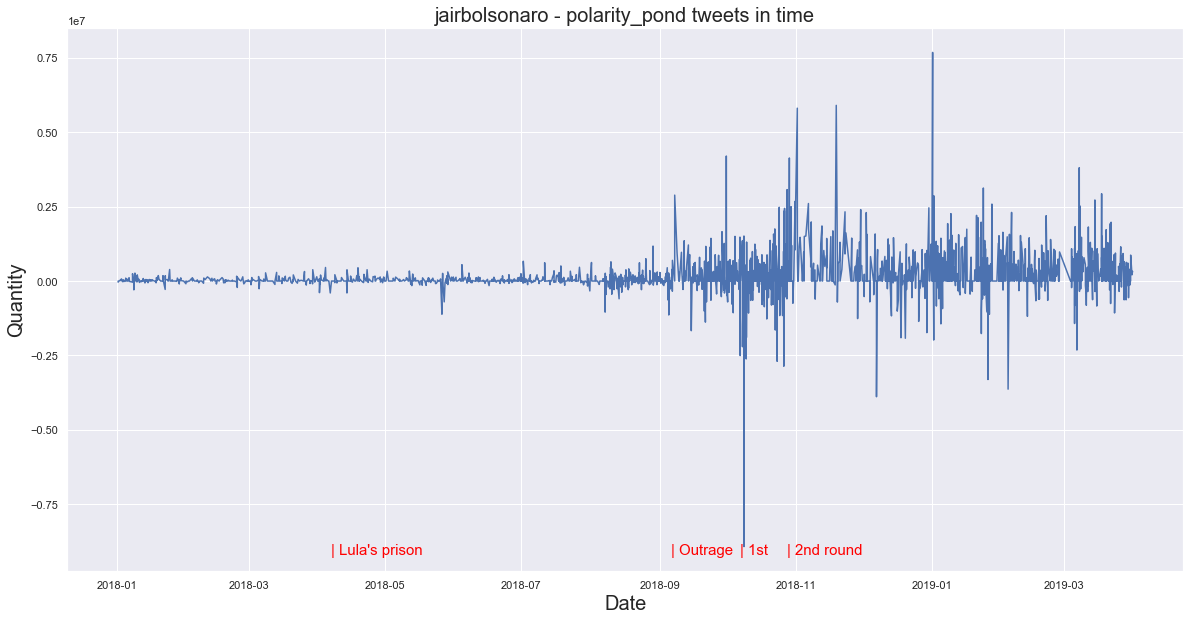

In [63]:
screen_name = 'jairbolsonaro'
dt = data[data.screen_name == screen_name]
plot_feature_timeline(dt, feature='polarity_pond', title=screen_name)

In [64]:
screen_name = 'jairbolsonaro'
dt_pos = data[(data.screen_name == screen_name) & (data.polarity_pond >0)]
dt_neg = data[(data.screen_name == screen_name) & (data.polarity_pond <0)]
print ("Number of Positive tweets: ", len(dt_pos))
print ("Number of Negative tweets: ", len(dt_neg))

Number of Positive tweets:  980
Number of Negative tweets:  381


,value
fear,41.8566
anger,36.4332
sadness,31.1289
disgust,24.2957
trust,23.25
anticipation,16.2734
surprise,8.89585
joy,8.06217


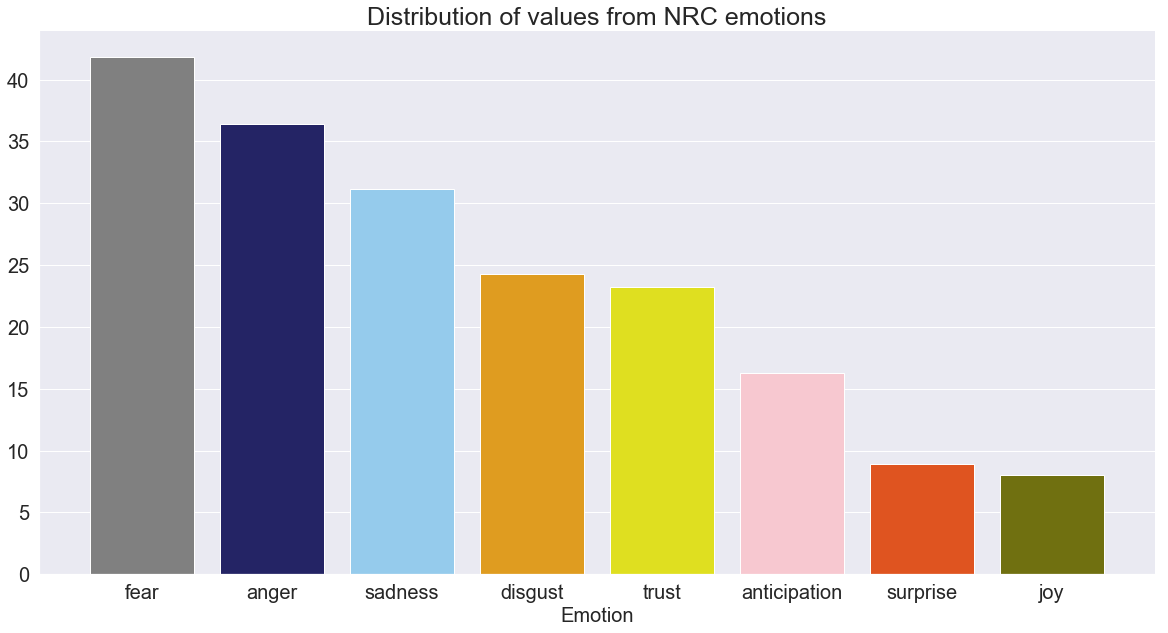

In [65]:
plot_emotions(dt_neg)

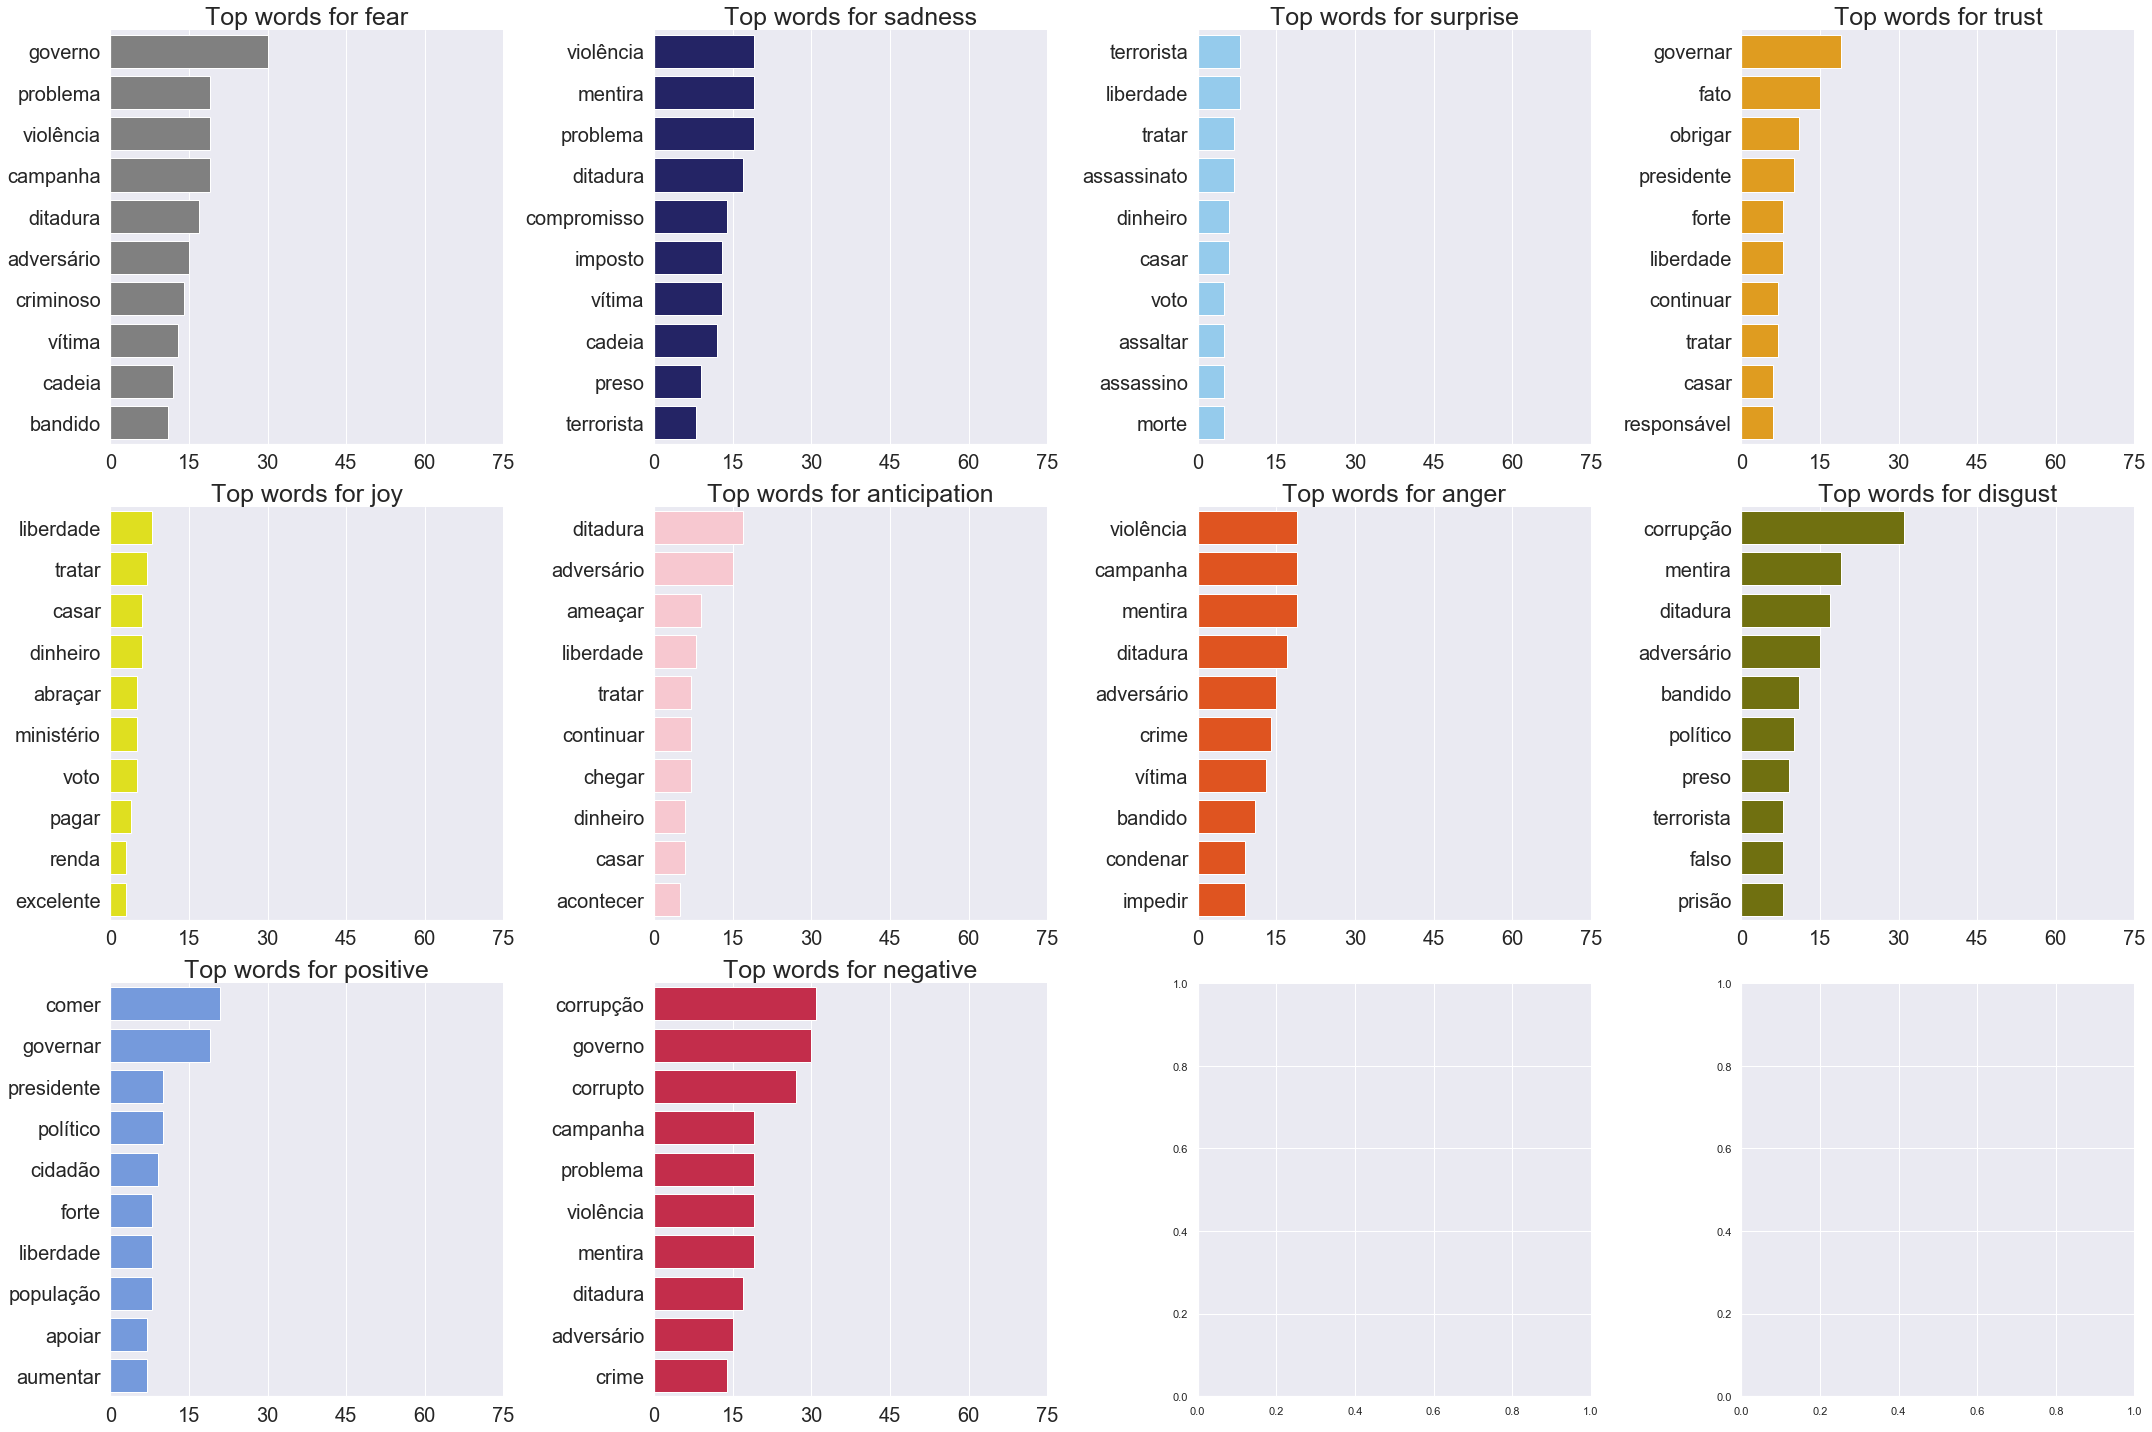

In [66]:
w_emo = get_words_emotions(dt_neg)

In [209]:
dt_neg.sort_values("polarity_pond", ascending=True).head()

,Unnamed: 0,created_at,retweets,favorites,text,clean_text,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,screen_name,polarity,polarity_pond
1391,1391,2018-10-08 18:03:11,29306.0,118994.0,"Meu compromisso é com a minha pátria, não com ...",compromisso pátrio corrupto cadeia,0.000000,0.000000,0.00000,0.250000,0.0,0.750000,0.000000,0.500000,0.0,0.000000,jairbolsonaro,-75.000000,-8.924550e+06
869,869,2018-12-07 01:17:36,18601.0,97211.0,Só não concorri com Lula porque ele está preso...,concorrer lula presar condenar corrupção 👍 🏻,0.200000,0.000000,0.20000,0.000000,0.0,0.400000,0.000000,0.000000,0.0,0.000000,jairbolsonaro,-40.000000,-3.888440e+06
430,430,2019-02-03 23:20:09,19210.0,145326.0,Fui informado de que um ator americano está me...,informar ator americano acusar censurar filmar...,0.250000,0.000000,0.25000,0.125000,0.0,0.250000,0.000000,0.125000,0.0,0.125000,jairbolsonaro,-25.000000,-3.633150e+06
504,504,2019-01-25 23:17:16,4389.0,33097.0,LAMENTÁVEL! https://t.co/dSjEKnN8fY,lamentável,0.000000,0.000000,0.00000,0.000000,0.0,1.000000,0.000000,1.000000,0.0,0.000000,jairbolsonaro,-100.000000,-3.309700e+06
1079,1079,2018-10-26 13:33:20,23811.0,94068.0,Haddad diz que sou responsável pela campanha m...,haddad responsável pelar campanha história ori...,0.130435,0.043478,0.26087,0.217391,0.0,0.391304,0.086957,0.173913,0.0,0.043478,jairbolsonaro,-30.434783,-2.862939e+06


In [210]:
show_tweet_annotation_by_index (1391) # Negative

Meu compromisso é com a minha pátria, não com corruptos na cadeia.

 [TEXT ANNOTATION]

compromisso  ==>  {'negative', 'sadness'}
pátrio  
corrupto  ==>  {'negative'}
cadeia  ==>  {'negative', 'fear', 'sadness'}


In [211]:
show_tweet_annotation_by_index (869)

Só não concorri com Lula porque ele está preso, condenado por corrupção! 👍🏻 https://t.co/0gb4qI0usE

 [TEXT ANNOTATION]

concorrer  
lula  
presar  
condenar  ==>  {'negative', 'anger'}
corrupção  ==>  {'disgust', 'negative'}
👍  
🏻  


In [212]:
show_tweet_annotation_by_index (430)

Fui informado de que um ator americano está me acusando de censurar seu filme no Brasil. Mentira! Tenho mais o que fazer. Boa noite a todos! 👍

 [TEXT ANNOTATION]

informar  ==>  {'trust'}
ator  
americano  
acusar  ==>  {'disgust', 'negative', 'fear', 'anger'}
censurar  
filmar  
brasil  
mentira  ==>  {'disgust', 'negative', 'sadness', 'anger'}
👍  


In [213]:
show_tweet_annotation_by_index (504) # PT critizing Bolsonaro due Disaster in Minas

LAMENTÁVEL! https://t.co/dSjEKnN8fY

 [TEXT ANNOTATION]

lamentável  ==>  {'negative', 'sadness'}


In [214]:
show_tweet_annotation_by_index (1079)

Haddad diz que sou responsável pela campanha mais baixa da história. Logo ele, que é orientado por um presidiário, esconde as cores do partido, finge ser religioso, joga bíblia no lixo, esconde apoio à ditadura venezuelana e espalha um monte de porcaria mentirosa ao meu respeito.

 [TEXT ANNOTATION]

haddad  
responsável  ==>  {'positive', 'trust'}
pelar  
campanha  ==>  {'negative', 'fear', 'anger'}
história  
orientar  
presidiário  ==>  {'disgust', 'negative', 'sadness', 'fear', 'anger'}
esconder  ==>  {'negative', 'disgust', 'sadness', 'fear'}
corar  
fingir  ==>  {'negative'}
religioso  
jogar  ==>  {'negative'}
bíblia  
lixar  
esconder  ==>  {'negative', 'disgust', 'sadness', 'fear'}
apoiar  ==>  {'positive'}
ditadura  ==>  {'anticipation', 'disgust', 'negative', 'sadness', 'fear', 'anger'}
venezuelano  
espalhar  
montar  
porcaria  ==>  {'disgust', 'negative'}
mentiroso  ==>  {'disgust', 'negative'}
respeitar  


,value
trust,158.466
anticipation,96.7587
joy,89.2285
surprise,51.8776
fear,36.0433
sadness,18.6281
disgust,17.8194
anger,17.6728


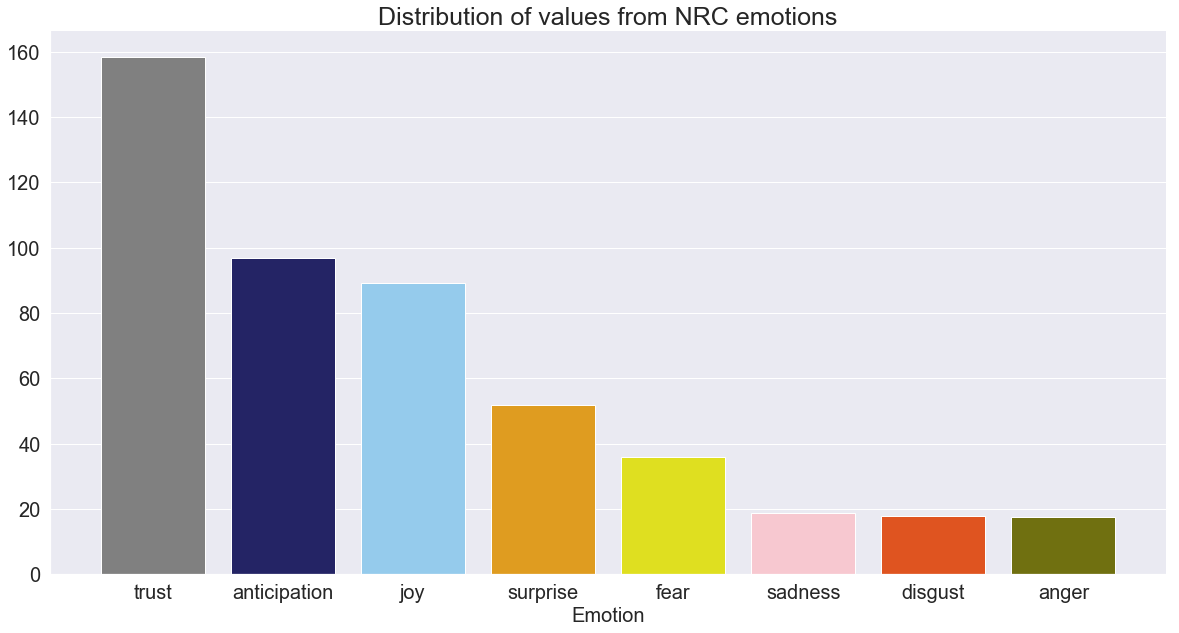

In [215]:
plot_emotions(dt_pos)

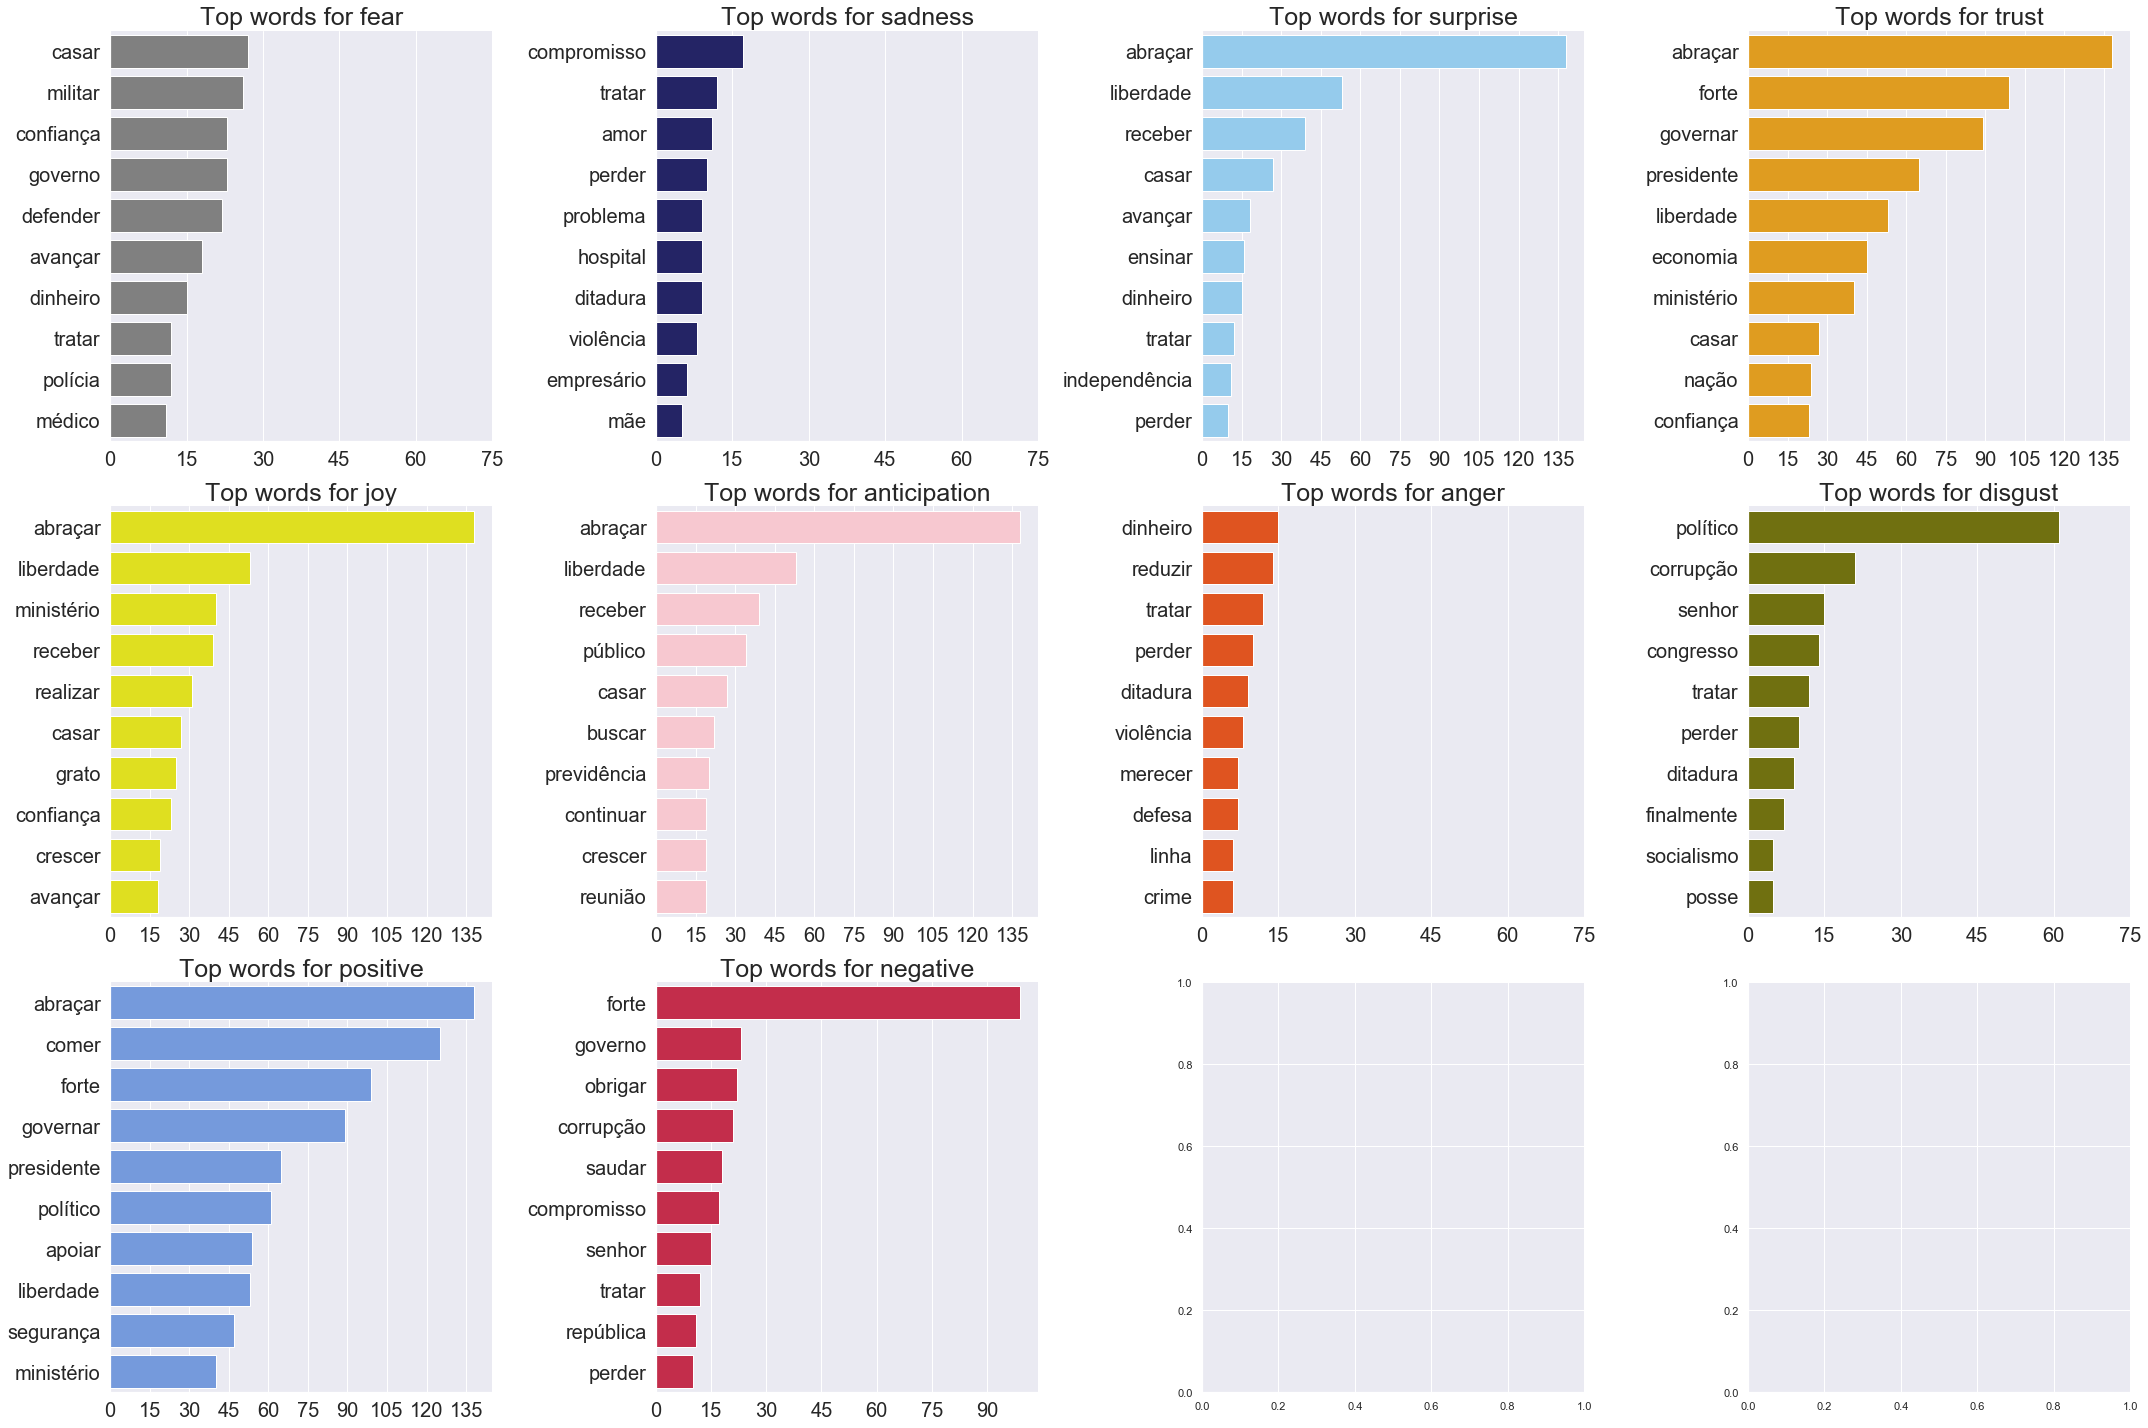

In [216]:
w_emo = get_words_emotions(dt_pos)

In [218]:
dt_pos.sort_values("polarity_pond", ascending=False).head()

,Unnamed: 0,created_at,retweets,favorites,text,clean_text,anger,anticipation,disgust,fear,joy,negative,positive,sadness,surprise,trust,screen_name,polarity,polarity_pond
732,732,2019-01-01 04:21:31,21366.0,153683.0,FELIZ 2019 🇧🇷🇧🇷🇧🇷,feliz 2019 🇧 🇷 🇧 🇷 🇧 🇷,0.0,0.500000,0.0,0.0000,0.500000,0.0000,0.500000,0.0,0.000,0.500000,jairbolsonaro,50.000000,7.684150e+06
944,944,2018-11-19 00:59:42,9240.0,59046.0,Só o amor constrói... https://t.co/XpTbWbcuKC,amor construir ...,0.0,0.500000,0.0,0.0000,0.500000,0.0000,1.000000,0.5,0.000,0.500000,jairbolsonaro,100.000000,5.904600e+06
1005,1005,2018-11-01 14:25:24,42808.0,203340.0,O juiz federal Sérgio Moro aceitou nosso convi...,juiz federal sérgio moro aceitar convite parir...,0.0,0.047619,0.0,0.0000,0.047619,0.0000,0.285714,0.0,0.000,0.142857,jairbolsonaro,28.571429,5.809714e+06
1506,1506,2018-09-30 19:43:01,11483.0,52522.0,- Obrigado Vitória!\n- Um forte abraço Espírit...,vitória forte abraçar espírito santo,0.0,0.600000,0.0,0.0000,0.600000,0.2000,1.000000,0.0,0.400,0.800000,jairbolsonaro,80.000000,4.201760e+06
1036,1036,2018-10-29 01:06:50,43820.0,220590.0,Recebemos há pouco ligação do Presidente dos E...,recebemos haver ligação presidente eua paraben...,0.0,0.125000,0.0,0.0625,0.187500,0.0625,0.250000,0.0,0.125,0.187500,jairbolsonaro,18.750000,4.136062e+06


In [219]:
show_tweet_annotation_by_index (732)

FELIZ 2019 🇧🇷🇧🇷🇧🇷

 [TEXT ANNOTATION]

feliz  ==>  {'anticipation', 'joy', 'trust', 'positive'}
2019  
🇧  
🇷  
🇧  
🇷  
🇧  
🇷  


In [220]:
show_tweet_annotation_by_index (944)

Só o amor constrói... https://t.co/XpTbWbcuKC

 [TEXT ANNOTATION]

amor  ==>  {'anticipation', 'joy', 'sadness', 'positive', 'trust'}
construir  ==>  {'positive'}
...  


In [221]:
show_tweet_annotation_by_index (1005)

O juiz federal Sérgio Moro aceitou nosso convite para o Ministério da Justiça e Segurança Pública. Sua agenda anti-corrupção, anti-crime organizado, bem como respeito à Constituição e às leis será o nosso norte!

 [TEXT ANNOTATION]

juiz  
federal  
sérgio  
moro  
aceitar  
convite  ==>  {'anticipation', 'positive'}
parir  
ministério  ==>  {'joy', 'positive', 'trust'}
justiça  ==>  {'positive', 'trust'}
segurança  ==>  {'positive'}
pública  
agendar  
anti-corrupção  
anti-crime  
organizar  ==>  {'positive'}
comer  ==>  {'positive'}
respeitar  
constituição  
s  
lei  ==>  {'trust'}
norte  


In [222]:
show_tweet_annotation_by_index (1506) # positive

- Obrigado Vitória!
- Um forte abraço Espírito Santo! https://t.co/TUAigCdHcT

 [TEXT ANNOTATION]

vitória  ==>  {'anticipation', 'joy', 'trust', 'positive'}
forte  ==>  {'negative', 'positive', 'trust'}
abraçar  ==>  {'anticipation', 'joy', 'trust', 'positive', 'surprise'}
espírito  ==>  {'positive'}
santo  ==>  {'anticipation', 'joy', 'trust', 'positive', 'surprise'}


In [223]:
show_tweet_annotation_by_index (1036)

Recebemos há pouco ligação do Presidente dos EUA, @realDonaldTrump nos parabenizando por esta eleição histórica! Manifestamos o desejo de aproximar ainda mais estas duas grande nações e avançarmos no caminho da liberdade e da prosperidade!

 [TEXT ANNOTATION]

recebemos  
haver  
ligação  ==>  {'negative'}
presidente  ==>  {'positive', 'trust'}
eua  
parabenizar  
eleição  
histórico  
manifestamos  
desejar  
aproximar  
nação  ==>  {'trust'}
avançar  ==>  {'anticipation', 'joy', 'positive', 'fear', 'surprise'}
caminhar  
liberdade  ==>  {'anticipation', 'joy', 'trust', 'positive', 'surprise'}
prosperidade  ==>  {'joy', 'positive'}


In [169]:
data.screen_name.value_counts()

BlogDoPim          3206
BolsonaroSP        3181
LulaOficial        3086
CarlosBolsonaro    3034
jairbolsonaro      2665
Haddad_Fernando    2211
gleisi             2058
FlavioBolsonaro    1069
Name: screen_name, dtype: int64

In [239]:
txt = "A alma jamais pode vaguear sem rumo, se tomar a Bíblia para lhe guiar os passos"
show_annotation(txt)

A  
alma  
jamais  
pode  
vaguear  
sem  ==>  {'negative'}
rumo,  
se  
tomar  
a  
Bíblia  
para  
lhe  
guiar  
os  
passos  


##  Aditional Tests

In [67]:
txt = "Manifestantes queimam carro em Honduras: Grupo pede o retorno de Zelaya à Presidência do país. En- contro na Costa Rica nessa quinta pode ser início do fim da crise."
show_annotation(txt)

Manifestantes  
queimam  
carro  
em  
Honduras:  
Grupo  
pede  
o  
retorno  
de  ==>  {'anger', 'negative'}
Zelaya  
à  
Presidência  
do  
país.  
En-  
contro  
na  
Costa  
Rica  
nessa  ==>  {'positive'}
quinta  
pode  
ser  
início  
do  
fim  
da  
crise.  


In [68]:
get_sentiments(txt)

{'joy': 0.0,
 'anger': 0.06666666666666667,
 'trust': 0.0,
 'surprise': 0.0,
 'negative': 0.06666666666666667,
 'fear': 0.0,
 'disgust': 0.0,
 'anticipation': 0.0,
 'positive': 0.03333333333333333,
 'sadness': 0.03333333333333333}